# Tweet Summarization:

### Engagements Method

Simply extract top k most engaging tweets. The presentation of these in chronological order becomes the summary.

### Subevent Method

Using event detection algorithm to identify active times within the event timeline. Top k active subevents are used, and summarized using the *Phrase Reinforcement Algorithm* proposed by [Sharifi et al.](http://comjnl.oxfordjournals.org/content/early/2013/10/08/comjnl.bxt109.full.pdf+html) for Twitter

**Phrase Reinforcement Algorithm**
- Node weights are calculated using: $weight(node) = count(node) - distance(root) * \ln(count(node))$
- The node count is the number of times that token appears at that node index relative the root node.

In [902]:
import pandas as pd
import numpy as np
import operator
import nltk
import string
import html
from collections import Counter
import math
import re
import ast
from sklearn.externals import joblib

In [903]:
k = 25

#### import data

In [904]:
event_name = input('Enter Event Name: ')
event_filename = re.sub("\W+", "", event_name.strip())

Enter Event Name: Xbox E3


In [905]:
df = pd.read_csv('data/final/event_%s_data.txt' % event_filename, sep='\t', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})
df.shape

(86475, 36)

In [906]:
dfsubevents = pd.read_csv('data/final/event_%s_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=0, index_col=0)
dfsubevents.index = dfsubevents.index.to_datetime()
dfsubevents.shape

(1440, 5)

In [907]:
df_e_subevents = pd.read_csv('data/final/event_%s_e_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=0, index_col=0)
df_e_subevents.index = df_e_subevents.index.to_datetime()
df_e_subevents.shape

(1440, 7)

#### clean text

In [908]:
#convert text to string
df['text'] = df['text'].apply(lambda text: html.unescape(str(text)))
#remove hashtag, mention symbols, any links
df['text_clean'] = df['text'].apply(lambda text: ' '.join([(w[:w.find('http')] if 'http' in w else w) for w in html.unescape(str(text)).replace('#', '').replace('@', '').split()]))
#initiate, apply tokenization
tknzr = nltk.TweetTokenizer()
#create stop words list
stop = nltk.corpus.stopwords.words('english')
punct = list(string.punctuation)
punct.extend(['...', '..', '…', '”', '“', '.@', 'RT'])
stop.extend(punct)
regex = re.compile('[^a-zA-Z\d\s:\']')
#removes non-alphanumeric
df['text_clean'] = df['text_clean'].apply(lambda text: ' '.join([w.lower() for w in tknzr.tokenize(text) if w.lower() not in punct and not regex.search(w)]))
df['text_clean_stopped'] = df['text_clean'].apply(lambda text: ' '.join([w.lower() for w in tknzr.tokenize(text) if w.lower() not in stop]))

## Engagements Method

In [909]:
df['engagements'] = df['favorite_count'] + df['retweet_count']

In [910]:
df['rank_engagements'] = df['engagements'].rank(axis=0, ascending=False)

In [911]:
summary_engagements = df.reset_index()[['created_at', 'rank_engagements', 'twitter_id', 'text',  'text_clean', 'user_screen_name']].sort_values(by='rank_engagements').iloc[:k]

In [912]:
summary_engagements.rename(columns={'user_screen_name' : 'show_text'}, inplace=True)
summary_engagements['show_text'] = '@'+summary_engagements['show_text']

## Subevent Method

#### get data from only top k subevents

In [913]:
dftemp = df[['twitter_id', 'created_at']]
dftemp['created_at'] = dftemp['created_at'].apply(lambda x: x.replace(second=0))
dftemp.set_index(['created_at'], inplace=True)

data = pd.merge(dftemp, dfsubevents, how='inner', left_index=True, right_index=True)
data.set_index('twitter_id', inplace=True)

data = pd.merge(df.set_index('twitter_id'), data, how='left', left_index=True, right_index=True)

data = data[data['rank_subevents'] <= k][['created_at', 'text', 'text_clean', 'text_clean_stopped', 'entities_hashtags', 'retweet_count', 'rank_subevents', 'news']]

data = data.reset_index().set_index('created_at')

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Apply Phrase Reinforcement Algorithm
#### framework
- for each subevent
    - count tokens in all corpus
        - save object of token counts, only those with frequencies > 1
    - get root token
        - most common token not in 100% of tweets
    - for each tweet, index the tokens
        - using only those tokens in above counter 
    - for each tweet, normalize the indices to the root index
        - creating tweet node indices
    - create corpus node graph
        - from node index min to node index max
        - count token occurrences at each node
            - for each node index, save object of token counts, only those with frequency > 1
    - compute node weights
    - sum node weights
    - rank tweets on sum node wieght
        - get highest ranked
- ouput summary tweets

#### n-gram function (not used)

In [914]:
from itertools import tee, islice

In [915]:
def get_ngrams(token_list, n):
    tlst = token_list
    while True:
        x, y = tee(tlst)
        gram = tuple(islice(x, n))
        if len(gram) == n:
            yield gram
            next(y)
            tlst = y
        else:
            break

#### run phrase reinforcement summarizer

In [916]:
%%time

summary = pd.DataFrame()
for i in range(k):
    #print('Rank: ', i+1)
    subevent = data[data['rank_subevents'] == i+1]
    
    try:
        #print(' data: ', subevent.shape[0])

        #finding duplicates, keep only first occurrence
        #print(' duplicates: ', subevent[subevent.duplicated('text_clean', keep='first')].shape[0])
        subevent.drop_duplicates('text_clean', keep='first', inplace=True)
        #print(' data: ', subevent.shape[0])

        subevent['text_length'] = subevent.apply(lambda x: len(x['text']), axis=1)

        #compute top hashtags (threshold >= 5% inclusion)
        allhashtags = [hashtag.lower() for hashtags in subevent['entities_hashtags'] for hashtag in ast.literal_eval(hashtags)]
        hashtagscounts = Counter(allhashtags)
        tophashtags = [hashtag[0] for hashtag in hashtagscounts.most_common(100) if hashtag[1] >= (subevent.shape[0] * .01)]
        tophashtags = [t for w in tophashtags for t in tknzr.tokenize(w)]

        #count tokens
        alltokens = [token for tweet in subevent['text_clean_stopped'] for token in tweet.split()]
        counts = Counter(alltokens)
        #terms_too_high = [term[0] for term in counts.most_common(100) if term[1] >= (subevent.shape[0] * .99)]
        terms_too_high = []
        
        #get root
        regex = re.compile('[^a-zA-Z\d\s:]')
        try:
            root, root_count = [term for term in counts.most_common() if term[0] not in terms_too_high and term[0] not in tophashtags and not regex.search(term[0])][0]
            #print(' root1:', root, root_count)
        except:
            try:
                root, root_count = [term for term in counts.most_common() if term[0] not in tophashtags and not regex.search(term[0])][0]
                #print(' root2:', root, root_count)
            except:
                try:
                    root, root_count = [term for term in counts.most_common() if not regex.search(term[0])][0]
                    #print(' root3:', root, root_count)
                except:
                    root, root_count = [term for term in counts.most_common()][0]
                    #print(' root4:', root, root_count)
       
        subevent['show_text'] = root
        counts = dict((token,count) for token,count in counts.items() if not token in terms_too_high and count > 1)

        #bigram counts
        root_bigram = ''
        bigram_count = 0
        try:
            bigram_counts = Counter(zip(alltokens,alltokens[1:]))
            bigrams = [bigram for bigram in bigram_counts.most_common(100) if bigram[1] > 1 and not any(t in bigram[0] for t in terms_too_high) and not any(t in bigram[0] for t in tophashtags) and ''.join(bigram[0]) not in tophashtags and not regex.search(' '.join(bigram[0])) and len(bigram[0]) == len(set(bigram[0]))]
            if len(bigrams) != 0 and bigrams[0][1] > root_count *.1 and bigrams[0][1] > 15:
                root_bigram = ' '.join(bigrams[0][0])
                bigram_count = bigrams[0][1]
                subevent['show_text'] = root_bigram
                root = root_bigram.split()[0]
                #print(' bigram: ', root_bigram, bigram_count)
        except TypeError:
            pass

        #ngram counts
        root_ngram = ''
        ngram_count = 0
        try:
            n = 3
            ngram_counts = Counter(get_ngrams(alltokens, n))
            ngrams = [ngram for ngram in ngram_counts.most_common(100) if ngram[1] > 1 and not any(t in ngram[0] for t in terms_too_high) and not any(t in ngram[0] for t in tophashtags) and ''.join(ngram[0]) not in tophashtags and not regex.search(' '.join(ngram[0])) and len(ngram[0]) == len(set(ngram[0]))]
            if len(ngrams) != 0 and ngrams[0][1] > bigram_count *.1 and ngrams[0][1] > 15:
                root_ngram = ' '.join(ngrams[0][0])
                ngram_count = ngrams[0][1]
                subevent['show_text'] = root_ngram
                root = root_ngram.split()[0]
                #print(' ngram:', root_ngram, ngram_count)
        except TypeError:
            pass

        roots_search = [' ' + r + ' ' for r in [[root,root_bigram][root_bigram != ''],root_ngram][root_ngram != ''].split()]
        roots = [[root,root_bigram][root_bigram != ''],root_ngram][root_ngram != ''].split()
        
        #index tokens in tweet
        subevent['node_indices'] = subevent['text_clean_stopped'].apply(lambda text: dict((token.lower(),index) for index,token in enumerate(text.split()) if token.lower() in counts and not token.lower() in tophashtags if all(w in text for w in roots_search)))
        #normalize indices relative to root
        subevent['node_indices'] = subevent['node_indices'].apply(lambda d: dict((token, token_index - d.get(root)) for token,token_index in d.items() if root in d.keys()))

        #graph token nodes around root node
        #get node counts
        nodelist = list(subevent['node_indices'])
        d = [index for l in [list(d.values()) for d in nodelist] for index in l]
        node_graph = {}
        node_counts = {}
        for i in range(min(d), max(d)+1):
            node_graph[i] = [token for d in nodelist for token,index in d.items() if index == i]
            node_counts[i] = dict((token,count) for token,count in Counter(node_graph[i]).items() if count > 1 and 'fuck' not in token)

        #compute node weights
        subevent['node_weights'] = subevent['node_indices'].apply(lambda d: dict((token, ((node_counts[token_index].get(token) if node_counts[token_index].get(token) else 0) + abs(token_index) * math.log1p(node_counts[token_index].get(token) if node_counts[token_index].get(token) else 0) if token not in roots else 1)) for token,token_index in d.items()))        

        #sum node weights
        subevent['text_weight'] = subevent['node_weights'].apply(lambda d: sum(d.values()))
        subevent['text_weight_e'] = subevent.apply(lambda x: x['text_weight'] + x['text_weight'] * math.log1p(x['retweet_count']), axis=1)
        
        #get highest ranked tweet, append to summary
        summary = summary.append(subevent.sort_values(by=['text_weight_e', 'text_length'], ascending=[False, False]).head(1))

    except (IndexError, ValueError):
        print('-'*50, '\n ERROR, taking most retweeted tweet\n', '-'*50)
        summary = summary.append(subevent.sort_values(by='retweet_count', ascending=False).head(1))
    
pr_summary_subevents = summary.reset_index()[['created_at', 'rank_subevents', 'twitter_id', 'text', 'text_clean', 'text_clean_stopped', 'node_weights', 'retweet_count', 'text_weight', 'text_weight_e', 'show_text', 'news']].sort_values(by='rank_subevents')

c:\miniconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipy

Wall time: 15.4 s


c:\miniconda3\lib\site-packages\ipykernel\__main__.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## E Subevent Method

#### get data from only top k subevents

In [917]:
dftemp = df[['twitter_id', 'created_at']]
dftemp['created_at'] = dftemp['created_at'].apply(lambda x: x.replace(second=0))
dftemp.set_index(['created_at'], inplace=True)

data = pd.merge(dftemp, df_e_subevents, how='inner', left_index=True, right_index=True)
data.set_index('twitter_id', inplace=True)

data = pd.merge(df.set_index('twitter_id'), data, how='left', left_index=True, right_index=True)

data = data[data['rank_subevents'] <= k][['created_at', 'text', 'text_clean', 'text_clean_stopped', 'entities_hashtags', 'retweet_count', 'rank_subevents', 'news']]

data = data.reset_index().set_index('created_at')

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### run phrase reinforcement summarizer

In [918]:
%%time

summary = pd.DataFrame()
for i in range(k):
    #print('Rank: ', i+1)
    subevent = data[data['rank_subevents'] == i+1]
    
    try:
        #print(' data: ', subevent.shape[0])

        #finding duplicates, keep only first occurrence
        #print(' duplicates: ', subevent[subevent.duplicated('text_clean', keep='first')].shape[0])
        subevent.drop_duplicates('text_clean', keep='first', inplace=True)
        #print(' data: ', subevent.shape[0])

        subevent['text_length'] = subevent.apply(lambda x: len(x['text']), axis=1)

        #compute top hashtags (threshold >= 5% inclusion)
        allhashtags = [hashtag.lower() for hashtags in subevent['entities_hashtags'] for hashtag in ast.literal_eval(hashtags)]
        hashtagscounts = Counter(allhashtags)
        tophashtags = [hashtag[0] for hashtag in hashtagscounts.most_common(100) if hashtag[1] >= (subevent.shape[0] * .05)]
        tophashtags = [t for w in tophashtags for t in tknzr.tokenize(w)]

        #count tokens
        alltokens = [token for tweet in subevent['text_clean_stopped'] for token in tweet.split()]
        counts = Counter(alltokens)
        #terms_too_high = [term[0] for term in counts.most_common(100) if term[1] >= (subevent.shape[0] * .99)]
        terms_too_high = []
        
        #get root
        regex = re.compile('[^a-zA-Z\d\s:]')
        try:
            root, root_count = [term for term in counts.most_common() if term[0] not in terms_too_high and term[0] not in tophashtags and not regex.search(term[0])][0]
            #print(' root1:', root, root_count)
        except:
            try:
                root, root_count = [term for term in counts.most_common() if term[0] not in tophashtags and not regex.search(term[0])][0]
                #print(' root2:', root, root_count)
            except:
                try:
                    root, root_count = [term for term in counts.most_common() if not regex.search(term[0])][0]
                    #print(' root3:', root, root_count)
                except:
                    root, root_count = [term for term in counts.most_common()][0]
                    #print(' root4:', root, root_count)
       
        subevent['show_text'] = root
        counts = dict((token,count) for token,count in counts.items() if not token in terms_too_high and count > 1)

        #bigram counts
        root_bigram = ''
        bigram_count = 0
        try:
            bigram_counts = Counter(zip(alltokens,alltokens[1:]))
            bigrams = [bigram for bigram in bigram_counts.most_common(100) if bigram[1] > 1 and not any(t in bigram[0] for t in terms_too_high) and not any(t in bigram[0] for t in tophashtags) and ''.join(bigram[0]) not in tophashtags and not regex.search(' '.join(bigram[0])) and len(bigram[0]) == len(set(bigram[0]))]
            if len(bigrams) != 0 and bigrams[0][1] > root_count *.1 and bigrams[0][1] > 15:
                root_bigram = ' '.join(bigrams[0][0])
                bigram_count = bigrams[0][1]
                subevent['show_text'] = root_bigram
                root = root_bigram.split()[0]
                #print(' bigram: ', root_bigram, bigram_count)
        except TypeError:
            pass

        #ngram counts
        root_ngram = ''
        ngram_count = 0
        try:
            n = 3
            ngram_counts = Counter(get_ngrams(alltokens, n))
            ngrams = [ngram for ngram in ngram_counts.most_common(100) if ngram[1] > 1 and not any(t in ngram[0] for t in terms_too_high) and not any(t in ngram[0] for t in tophashtags) and ''.join(ngram[0]) not in tophashtags and not regex.search(' '.join(ngram[0])) and len(ngram[0]) == len(set(ngram[0]))]
            if len(ngrams) != 0 and ngrams[0][1] > bigram_count *.1 and ngrams[0][1] > 15:
                root_ngram = ' '.join(ngrams[0][0])
                ngram_count = ngrams[0][1]
                subevent['show_text'] = root_ngram
                root = root_ngram.split()[0]
                #print(' ngram:', root_ngram, ngram_count)
        except TypeError:
            pass

        roots_search = [' ' + r + ' ' for r in [[root,root_bigram][root_bigram != ''],root_ngram][root_ngram != ''].split()]
        roots = [[root,root_bigram][root_bigram != ''],root_ngram][root_ngram != ''].split()
        
        #index tokens in tweet
        subevent['node_indices'] = subevent['text_clean_stopped'].apply(lambda text: dict((token.lower(),index) for index,token in enumerate(text.split()) if token.lower() in counts and not token.lower() in tophashtags if all(w in text for w in roots_search)))
        #normalize indices relative to root
        subevent['node_indices'] = subevent['node_indices'].apply(lambda d: dict((token, token_index - d.get(root)) for token,token_index in d.items() if root in d.keys()))

        #graph token nodes around root node
        #get node counts
        nodelist = list(subevent['node_indices'])
        d = [index for l in [list(d.values()) for d in nodelist] for index in l]
        node_graph = {}
        node_counts = {}
        for i in range(min(d), max(d)+1):
            node_graph[i] = [token for d in nodelist for token,index in d.items() if index == i]
            node_counts[i] = dict((token,count) for token,count in Counter(node_graph[i]).items() if count > 1 and 'fuck' not in token)

        #compute node weights
        subevent['node_weights'] = subevent['node_indices'].apply(lambda d: dict((token, ((node_counts[token_index].get(token) if node_counts[token_index].get(token) else 0) + abs(token_index) * math.log1p(node_counts[token_index].get(token) if node_counts[token_index].get(token) else 0) if token not in roots else 1)) for token,token_index in d.items()))        

        #sum node weights
        subevent['text_weight'] = subevent['node_weights'].apply(lambda d: sum(d.values()))
        subevent['text_weight_e'] = subevent.apply(lambda x: x['text_weight'] + x['text_weight'] * math.log1p(x['retweet_count']), axis=1)
        
        #get highest ranked tweet, append to summary
        summary = summary.append(subevent.sort_values(by=['text_weight_e', 'text_length'], ascending=[False, False]).head(1))

    except (IndexError, ValueError):
        print('-'*50, '\n ERROR, taking most retweeted tweet\n', '-'*50)
        summary = summary.append(subevent.sort_values(by='retweet_count', ascending=False).head(1))
    
pr_summary_e_subevents = summary.reset_index()[['created_at', 'rank_subevents', 'twitter_id', 'text', 'text_clean', 'text_clean_stopped', 'node_weights', 'retweet_count', 'text_weight', 'show_text', 'news']].sort_values(by='rank_subevents')

c:\miniconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipy

Wall time: 16.8 s


#### run phrase reinforcement summarizer, on classified news

In [919]:
%%time

summary = pd.DataFrame()
for i in range(k):
    #print('Rank: ', i+1)
    subevent = data[(data['rank_subevents'] == i+1) & (data['news'] == 1)]
        
    first = True
    while True:
        try:
            #print(' data: ', subevent.shape[0])

            #finding duplicates, keep only first occurrence
            #print(' duplicates: ', subevent[subevent.duplicated('text_clean', keep='first')].shape[0])
            subevent.drop_duplicates('text_clean', keep='first', inplace=True)
            #print(' data: ', subevent.shape[0])

            subevent['text_length'] = subevent.apply(lambda x: len(x['text']), axis=1)

            #compute top hashtags (threshold >= 5% inclusion)
            allhashtags = [hashtag.lower() for hashtags in subevent['entities_hashtags'] for hashtag in ast.literal_eval(hashtags)]
            hashtagscounts = Counter(allhashtags)
            tophashtags = [hashtag[0] for hashtag in hashtagscounts.most_common(100) if hashtag[1] >= (subevent.shape[0] * .05)]
            tophashtags = [t for w in tophashtags for t in tknzr.tokenize(w)]

            #count tokens
            alltokens = [token for tweet in subevent['text_clean_stopped'] for token in tweet.split()]
            counts = Counter(alltokens)
            #terms_too_high = [term[0] for term in counts.most_common(100) if term[1] >= (subevent.shape[0] * .99)]
            terms_too_high = []

            #get root
            regex = re.compile('[^a-zA-Z\d\s:]')
            try:
                root, root_count = [term for term in counts.most_common() if term[0] not in terms_too_high and term[0] not in tophashtags and not regex.search(term[0])][0]
                #print(' root1:', root, root_count)
            except:
                try:
                    root, root_count = [term for term in counts.most_common() if term[0] not in tophashtags and not regex.search(term[0])][0]
                    #print(' root2:', root, root_count)
                except:
                    try:
                        root, root_count = [term for term in counts.most_common() if not regex.search(term[0])][0]
                        #print(' root3:', root, root_count)
                    except:
                        root, root_count = [term for term in counts.most_common()][0]
                        #print(' root4:', root, root_count)

            subevent['show_text'] = root
            counts = dict((token,count) for token,count in counts.items() if not token in terms_too_high and count > 1)

            #bigram counts
            root_bigram = ''
            bigram_count = 0
            try:
                bigram_counts = Counter(zip(alltokens,alltokens[1:]))
                bigrams = [bigram for bigram in bigram_counts.most_common(100) if bigram[1] > 1 and not any(t in bigram[0] for t in terms_too_high) and not any(t in bigram[0] for t in tophashtags) and ''.join(bigram[0]) not in tophashtags and not regex.search(' '.join(bigram[0])) and len(bigram[0]) == len(set(bigram[0]))]
                if len(bigrams) != 0 and bigrams[0][1] > root_count *.1 and bigrams[0][1] > 15:
                    root_bigram = ' '.join(bigrams[0][0])
                    bigram_count = bigrams[0][1]
                    subevent['show_text'] = root_bigram
                    root = root_bigram.split()[0]
                    #print(' bigram: ', root_bigram, bigram_count)
            except TypeError:
                pass

            #ngram counts
            root_ngram = ''
            ngram_count = 0
            try:
                n = 3
                ngram_counts = Counter(get_ngrams(alltokens, n))
                ngrams = [ngram for ngram in ngram_counts.most_common(100) if ngram[1] > 1 and not any(t in ngram[0] for t in terms_too_high) and not any(t in ngram[0] for t in tophashtags) and ''.join(ngram[0]) not in tophashtags and not regex.search(' '.join(ngram[0])) and len(ngram[0]) == len(set(ngram[0]))]
                if len(ngrams) != 0 and ngrams[0][1] > bigram_count *.1 and ngrams[0][1] > 15:
                    root_ngram = ' '.join(ngrams[0][0])
                    ngram_count = ngrams[0][1]
                    subevent['show_text'] = root_ngram
                    root = root_ngram.split()[0]
                    #print(' ngram:', root_ngram, ngram_count)
            except TypeError:
                pass

            roots_search = [' ' + r + ' ' for r in [[root,root_bigram][root_bigram != ''],root_ngram][root_ngram != ''].split()]
            roots = [[root,root_bigram][root_bigram != ''],root_ngram][root_ngram != ''].split()

            #index tokens in tweet
            subevent['node_indices'] = subevent['text_clean_stopped'].apply(lambda text: dict((token.lower(),index) for index,token in enumerate(text.split()) if token.lower() in counts and not token.lower() in tophashtags if all(w in text for w in roots_search)))
            #normalize indices relative to root
            subevent['node_indices'] = subevent['node_indices'].apply(lambda d: dict((token, token_index - d.get(root)) for token,token_index in d.items() if root in d.keys()))

            #graph token nodes around root node
            #get node counts
            nodelist = list(subevent['node_indices'])
            d = [index for l in [list(d.values()) for d in nodelist] for index in l]
            node_graph = {}
            node_counts = {}
            for i in range(min(d), max(d)+1):
                node_graph[i] = [token for d in nodelist for token,index in d.items() if index == i]
                node_counts[i] = dict((token,count) for token,count in Counter(node_graph[i]).items() if count > 1 and 'fuck' not in token)

            #compute node weights
            subevent['node_weights'] = subevent['node_indices'].apply(lambda d: dict((token, ((node_counts[token_index].get(token) if node_counts[token_index].get(token) else 0) + abs(token_index) * math.log1p(node_counts[token_index].get(token) if node_counts[token_index].get(token) else 0) if token not in roots else 1)) for token,token_index in d.items()))        

            #sum node weights
            subevent['text_weight'] = subevent['node_weights'].apply(lambda d: sum(d.values()))
            subevent['text_weight_e'] = subevent.apply(lambda x: x['text_weight'] + x['text_weight'] * math.log1p(x['retweet_count']), axis=1)

            #get highest ranked tweet, append to summary
            summary = summary.append(subevent[subevent['text_weight'] != 0].sort_values(by=['text_weight_e', 'text_length'], ascending=[False, False]).head(1))
            break

        except (IndexError, ValueError):
            if first:
                print('-'*50, '\n ERROR, not enough news, using all data\n', '-'*50)
                subevent = data[(data['rank_subevents'] == i+1)]
                first = False
                continue
            else:
                print('-'*50, '\n ERROR, taking most retweeted tweet\n', '-'*50)
                summary = summary.append(subevent.sort_values(by='retweet_count', ascending=False).head(1))
                break

prplus_summary_e_subevents = summary.reset_index()[['created_at', 'rank_subevents', 'twitter_id', 'text', 'text_clean', 'text_clean_stopped', 'node_weights', 'retweet_count', 'text_weight', 'show_text', 'news']].sort_values(by='rank_subevents')

c:\miniconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipy

Wall time: 13.5 s


## Merge Summaries with Event Timeline

In [920]:
timeline = dfsubevents.reset_index()[['index', 'count']]
timeline.columns = ['created_at', 'volume']

In [921]:
summary_engagements['created_at'] = summary_engagements['created_at'].apply(lambda x: x.replace(second=0))
timelinesummary_engagements = pd.merge(timeline, summary_engagements, how='left', on='created_at')
timelinesummary_engagements.rename(columns={'rank_engagements': 'rank'}, inplace=True)

timelinesummary_engagements.to_csv('data/final/summary/event_%s_summary_engagements.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)

In [922]:
pr_summary_subevents['created_at'] = pr_summary_subevents['created_at'].apply(lambda x: x.replace(second=0))
timelinesummary_pr_subevents = pd.merge(timeline, pr_summary_subevents, how='left', on='created_at')
timelinesummary_pr_subevents.rename(columns={'rank_subevents': 'rank'}, inplace=True)

timelinesummary_pr_subevents.to_csv('data/final/summary/event_%s_summary_pr_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)

In [923]:
pr_summary_e_subevents['created_at'] = pr_summary_e_subevents['created_at'].apply(lambda x: x.replace(second=0))
timelinesummary_pr_e_subevents = pd.merge(timeline, pr_summary_e_subevents, how='left', on='created_at')
timelinesummary_pr_e_subevents.rename(columns={'rank_subevents': 'rank'}, inplace=True)

timelinesummary_pr_e_subevents.to_csv('data/final/summary/event_%s_summary_pr_e_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)

In [924]:
prplus_summary_e_subevents['created_at'] = prplus_summary_e_subevents['created_at'].apply(lambda x: x.replace(second=0))
timelinesummary_prplus_e_subevents = pd.merge(timeline, prplus_summary_e_subevents, how='left', on='created_at')
timelinesummary_prplus_e_subevents.rename(columns={'rank_subevents': 'rank'}, inplace=True)

timelinesummary_prplus_e_subevents.to_csv('data/final/summary/event_%s_summary_prplus_e_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)

## Print Summaries
- static examples

In [925]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.options.display.max_colwidth = 200

### Engagements

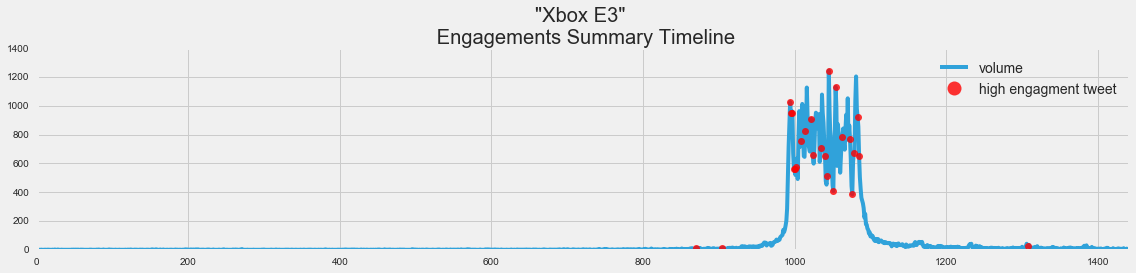

In [926]:
plt.title('"%s" \n Engagements Summary Timeline' % event_name)
ax = timelinesummary_engagements['volume'].plot(figsize=(16,4))
timelinesummary_engagements[timelinesummary_engagements['rank'] <= k]['volume'].plot(ax=ax, style='ro', alpha=.8, label='high engagment tweet')
plt.legend(loc='best', markerscale=2, fontsize=14)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/summary_%s_engagements.png' % event_filename)

### Subevents

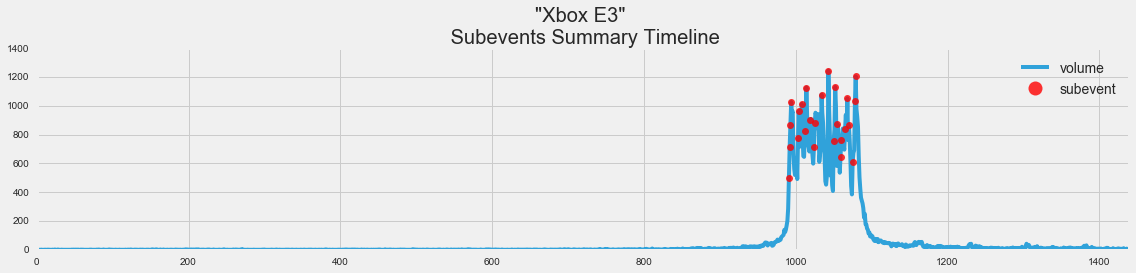

In [927]:
plt.title('"%s" \n Subevents Summary Timeline' % event_name)
ax = timelinesummary_pr_subevents['volume'].plot(figsize=(16,4))
timelinesummary_pr_subevents[timelinesummary_pr_subevents['rank'] <= k]['volume'].plot(ax=ax, style='ro', alpha=.8, label='subevent')
plt.legend(loc='best', markerscale=2, fontsize=14)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/summary_%s_subevents.png' % event_filename)

### E Subevents

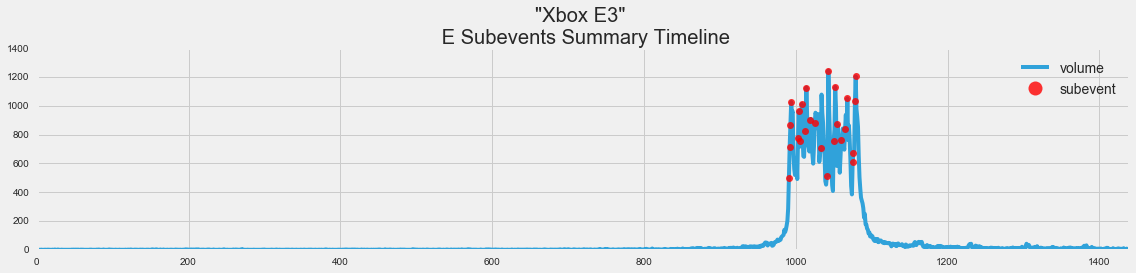

In [928]:
plt.title('"%s" \n E Subevents Summary Timeline' % event_name)
ax = timelinesummary_pr_e_subevents['volume'].plot(figsize=(16,4))
timelinesummary_pr_e_subevents[timelinesummary_pr_e_subevents['rank'] <= k]['volume'].plot(ax=ax, style='ro', alpha=.8, label='subevent')
plt.legend(loc='best', markerscale=2, fontsize=14)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/summary_%s_e_subevents.png' % event_filename)

#### text summaries

In [929]:
#summary_engagements.set_index('created_at').sort_index(ascending=True)

In [930]:
#timelinesummary_pr_subevents[timelinesummary_pr_subevents['rank'] <= k].set_index('created_at').sort_index(ascending=True)

In [931]:
#timelinesummary_pr_e_subevents[timelinesummary_pr_e_subevents['rank'] <= k].set_index('created_at').sort_index(ascending=True)

In [932]:
#timelinesummary_prplus_e_subevents[timelinesummary_prplus_e_subevents['rank'] <= k].set_index('created_at').sort_index(ascending=True)

### export summaries for evaluation

In [933]:
summary_engagements.to_csv('data/final/summary/foreval_event_%s_summary_engagements.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)
pr_summary_subevents.to_csv('data/final/summary/foreval_event_%s_summary_pr_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)
pr_summary_e_subevents.to_csv('data/final/summary/foreval_event_%s_summary_pr_e_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)
prplus_summary_e_subevents.to_csv('data/final/summary/foreval_event_%s_summary_prplus_e_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)